# Estimating Camera transformation matrices
Taking a series of pictures and estimating the camera transform matrices to produce the training JSON and other datasets. 

In [2]:
import matplotlib.pyplot as plt
import PIL.Image as Image
import numpy as np
from skimage import io
from random import randint
import cv2

In [3]:
def imshow(images, titles, callback = None, nrows = 0, ncols=0):
    """Plot a multiple images with titles.

    Parameters
    ----------
    images : image list
    titles : title list
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    if ncols == 0 and nrows == 0:
      ncols = len(images)
      nrows = 1
    if ncols == 0:
      ncols = len(images) // nrows
    if nrows == 0:
      nrows = len(images) // ncols
      
    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows, squeeze=False, figsize = None)
    for i, image in enumerate(images):
        axeslist.ravel()[i].imshow(image, cmap=plt.gray(), vmin=0, vmax=255)
        axeslist.ravel()[i].set_title(titles[i])
        axeslist.ravel()[i].set_axis_off()
    plt.tight_layout() # optional

    text=fig.text(0,0, "", va="bottom", ha="left")
    def onclick(event):
        [i],[j] = np.where(axeslist == event.inaxes)
        callback(axeslist, [i,j], [event.xdata, event.ydata], text)
    
    # Create an hard reference to the callback not to be cleared by the garbage collector
    ka = fig.canvas.mpl_connect('button_press_event', onclick)
    return axeslist

## Processing a video as input

In [4]:
#open video and read frames
video_path = "/home/pierina/Gaussian_Surface_Reconstruction/home_made_data/plant_lego.mp4"
cap = cv2.VideoCapture(video_path)

In [5]:
captured_frames = []
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        break
    captured_frames.append(frame)
cap.release()
cv2.destroyAllWindows()

In [6]:
print(f"Total frames captured: {len(captured_frames)}")

Total frames captured: 1504


In [7]:
#clean the data and keep only unblurry frames
clean_frames = []
for i, frame in enumerate(captured_frames):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
    if laplacian_var >150:  # threshold for blurriness
        clean_frames.append((i, laplacian_var))
print(f"Total clean frames: {len(clean_frames)}")
print(clean_frames[:10])

Total clean frames: 563
[(0, 161.57798451288494), (7, 150.01086644766428), (8, 159.08463868676432), (9, 152.8579132127687), (15, 172.61809194806318), (16, 182.58546677813231), (17, 183.58666295694763), (18, 180.62817469134168), (19, 157.8115227784828), (28, 153.93020193220076)]


In [8]:
def quick_sort(arr):
    if len(arr) <= 1:
        return arr
    
    pivot = arr[randint(0, len(arr) - 1)][1]

    less = []
    equal = []
    greater = []
    
    for x in arr:
        if x[1] < pivot:
            less.append(x)
        elif x[1] == pivot:
            equal.append(x)
        else:
            greater.append(x)

    return quick_sort(less) + equal + quick_sort(greater)
sorted_clean_frames = quick_sort(clean_frames)

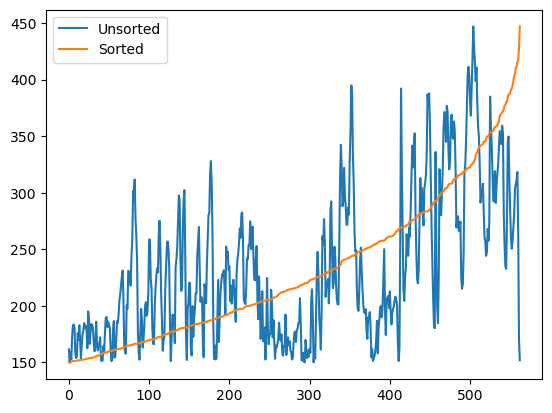

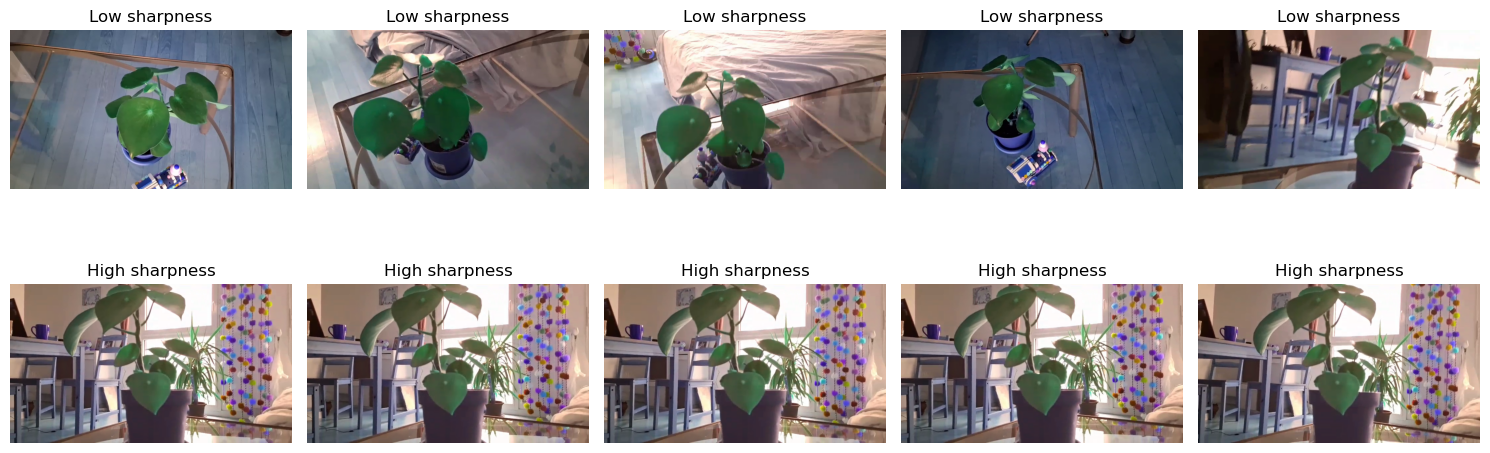

In [9]:
plt.plot([cf[1] for cf in clean_frames], label="Unsorted")
plt.plot([cf[1] for cf in sorted_clean_frames], label="Sorted")
plt.legend()
plt.show()

N = 5  # or however many you want to show

fig, axis = plt.subplots(2, N, figsize=(15, 6))

for i in range(N):
    img1 = captured_frames[sorted_clean_frames[i][0]]           # lowest sharpness
    img2 = captured_frames[sorted_clean_frames[-(i+1)][0]]       # highest sharpness

    axis[0, i].imshow(img1)
    axis[0, i].axis('off')
    axis[0, i].set_title("Low sharpness")

    axis[1, i].imshow(img2)
    axis[1, i].axis('off')
    axis[1, i].set_title("High sharpness")

plt.tight_layout()
plt.show()

In [ ]:
#run to save images
import os
def save_clean_frames():
    user_input = input("Do you want to save the clean frames as images? (y/n): ")
    if user_input.lower() != 'y':
        print("Exiting without saving images.")
        return
    #save into folder as images labeled r_0 to r_n, every 10 frames
    #create folder if it does not exist
    
    output_folder = "/home/pierina/Gaussian_Surface_Reconstruction/home_made_data/images/"
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    for i, frame in enumerate(captured_frames, start=0):
        img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        img.save(f"/home/pierina/Gaussian_Surface_Reconstruction/home_made_data/images/r_{i//10}.png")


In [17]:
#enter y to confirm saving images, any other key to skip
save_clean_frames()

## Estimating the Camera matrix

Use convert.py
```sh
python3 -m convert.py -s <folder containing images folder>
```

to read the binaries :
```sh
colmap model_converter --input_path <folder containing images folder>/sparse/0/ --output_path <folder containing images foler>/sparse/0/ --output_type txt
```